In [1]:
!pip install autocorrect
import sys 
!{sys.executable} -m pip install contractions
!pip install zeugma

     |████████████████████████████████| 624kB 16.6MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.3.0-cp36-none-any.whl size=621588 sha256=07447c3eecc5b33d5c8af2d8aad2eac3c59c3e13427af7d9e8b92f6da8ef740a
  Stored in directory: /root/.cache/pip/wheels/cc/1c/30/6b0199afbd20eef5959f5eaa0ead86aeef84391740482b2279
Successfully built autocorrect
     |████████████████████████████████| 327kB 28.1MB/s 
     |████████████████████████████████| 266kB 53.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84340 sha256=2a0fb1996bbf9f806ec374ec9284164dfb507d774a06026094cbda8320764e9d
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick
  Created wheel for zeugma: filename=zeugma-0.48-cp36-none-any.whl size=8778 sha256=227276bae02b4d9ef66ebe7b27e28e6efaa3995f60730b71b28ba7d8c91ad456
  Stored in directory: /root/.cache/pip/wheels/6a/b5/bc/5183ac478b00

In [2]:
import re
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --------------------------------------------------------------
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("stopwords")
# --------------------------------------------------------------
import contractions
from autocorrect import Speller
# --------------------------------------------------------------
import pickle 
# --------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,matthews_corrcoef
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
data = pd.read_json("News_Category_Dataset_v2.json", 
                    lines = True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [4]:
new_data = data.drop(['date','link'],axis = 1).copy()

Checking for the distribution of classes:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


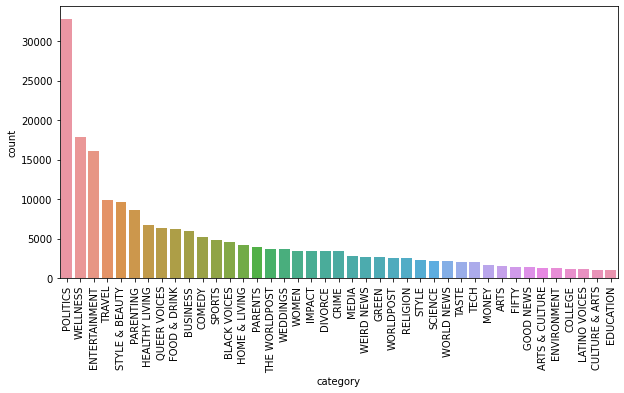

In [8]:
plt.figure(figsize = (10,5))
plt.xticks(rotation=90)
sns.countplot(new_data.category, 
              order=new_data.category.value_counts().index)

Mapping Similar categories together:

In [9]:
new_data.category = new_data.category.map(lambda x: "WORLDPOST" if x
                                          == "THE WORLDPOST" else x)
new_data.category = new_data.category.map(lambda x: "EDUCATION" if x
                                          == "COLLEGE" else x)
new_data.category = new_data.category.map(lambda x: "ARTS & CULTURE" 
                                          if x == "ARTS" else x)
new_data.category = new_data.category.map(lambda x: "FOOD & DRINK"
                                          if x == "TASTE" else x)
new_data.category = new_data.category.map(lambda x: "PARENTING" if x
                                          == "PARENTS" else x)
new_data.category = new_data.category.map(lambda x: "STYLE & BEAUTY"
                                          if x == "STYLE" else x)
new_data.category = new_data.category.map(lambda x: "WORLDPOST" if x
                                          == "WORLD NEWS" else x)
print(new_data.category.nunique())
print(new_data.category.value_counts())

34
POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
PARENTING         12632
STYLE & BEAUTY    11903
TRAVEL             9887
WORLDPOST          8420
FOOD & DRINK       8322
HEALTHY LIVING     6694
QUEER VOICES       6314
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
ARTS & CULTURE     2848
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
SCIENCE            2178
EDUCATION          2148
TECH               2082
MONEY              1707
FIFTY              1401
GOOD NEWS          1398
ENVIRONMENT        1323
LATINO VOICES      1129
CULTURE & ARTS     1030
Name: category, dtype: int64


Handling Null Values:


In [11]:
for i in new_data.columns:
  print(i)
  print(len(new_data[new_data[i] == ""]))
  print("--------------------")


category
0
--------------------
headline
6
--------------------
authors
36620
--------------------
short_description
19712
--------------------


In [13]:
new_data[new_data['headline'] == ""]

,category,headline,authors,short_description
82270,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",
86893,RELIGION,,"Matthew Fox, ContributorRadical theologian Mat...",Let everyone not wrapped in tired and disprove...
95001,WORLDPOST,,"Natasha Srdoc, ContributorAuthor, Economist, C...",
100426,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",
101479,MEDIA,,"Gary Snyder, ContributorWriter and Media Strat...",
113471,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",


In [14]:
new_data = new_data[new_data['headline'] != ""]
new_data = new_data[new_data['short_description'] != ""]

Now that we have removed null values we can create a new data frame to move forward.

In [15]:
df = new_data[['headline','short_description','category']]
df.reset_index(drop=True)
df.head()

,headline,short_description,category
0,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",ENTERTAINMENT


In [16]:
df['total'] = df['headline'] + " " + df['short_description']
df.head(2)

,headline,short_description,category,total
0,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...


In [17]:
df_cleaned = df[['total','category']]

function to expand contractions:


In [18]:
def expand_contractions(text):
  sent = ""
  for word in text.split():
    sent = sent + " " + contractions.fix(word)
  return sent.lower()

 function to correct the spelling of words:

In [19]:
def spell_check(text):
  spell = Speller()
  sent = " "
  spells = [spell(w) for w in (nltk.word_tokenize(text))]  
  return sent.join(spells)
spell_check(expand_contractions(df_cleaned.total[20]))

"weird father 's day gifts your dad does not know he wants ( but he does ) why buy a boring tie when you can give him textile plush toys ?"

function to preprocess the whole data dataset:

In [22]:
def text_preprocess(data,x):
  lemmatizer = WordNetLemmatizer()
  for i,row in data.iterrows():
      filter_Sentence = ''
      sentence = row[x]
      sentence = expand_contractions(sentence)
      #sentence = spell_check(sentence)
      sentence = re.sub(r'[^\w\s]',' ',sentence)
      #removing extra space
      sentence = re.sub(r"\s+"," ", sentence, flags = re.I)
      sentence = re.sub(r"\d", " ", sentence)#removing digits
      #removing single characters
      sentence = re.sub(r"\s+[a-zA-Z]\s+", " ", sentence)
      #removing multiple characters
      sentence = re.sub(r"[,@\'?\.$%_]", "", sentence, flags=re.I)
      words = nltk.word_tokenize(sentence)
     #words = [w for w in words if not w in stop_words]
      for word in words:
          #filter_Sentence = filter_Sentence + ' ' + str(word)
          filter_Sentence = filter_Sentence + ' ' + str(lemmatizer.lemmatize(word))
      data.loc[i,x] = sentence
  return data
text_preprocess(df_cleaned,'total').head()


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,total,category
0,there were mass shootings in texas last wee...,CRIME
1,will smith joins diplo and nicky jam for the ...,ENTERTAINMENT
2,hugh grant marries for the first time at age ...,ENTERTAINMENT
3,jim carrey blasts castrato adam schiff and de...,ENTERTAINMENT
4,julianna margulies uses donald trump poop bag...,ENTERTAINMENT


In [23]:
df_cleaned.to_csv('clean.csv', index = False)

In [24]:
df_cleaned = pd.read_csv("/content/clean.csv")
df_cleaned.head()

,total,category
0,there were mass shootings in texas last wee...,CRIME
1,will smith joins diplo and nicky jam for the ...,ENTERTAINMENT
2,hugh grant marries for the first time at age ...,ENTERTAINMENT
3,jim carrey blasts castrato adam schiff and de...,ENTERTAINMENT
4,julianna margulies uses donald trump poop bag...,ENTERTAINMENT


Using TFIDF Vectorizer to generate word vectors:


In [25]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_cleaned['total'])
X.shape

(181140, 83559)

In [26]:

pickle.dump(tfidf, open("tfidf.pkl","wb"))

Splitting the data into train and test set:

In [27]:
y = df_cleaned['category']
x_train,x_test,y_train,y_test = train_test_split(X, y,
                                                 test_size = 0.2)

In [28]:
Lg = LogisticRegression(max_iter = 1000).fit(x_train,y_train)

In [29]:
pred = Lg.predict(x_test)
print(accuracy_score(y_test,pred))
print(matthews_corrcoef(y_test, pred))

0.650049685326267
0.6230436183706591


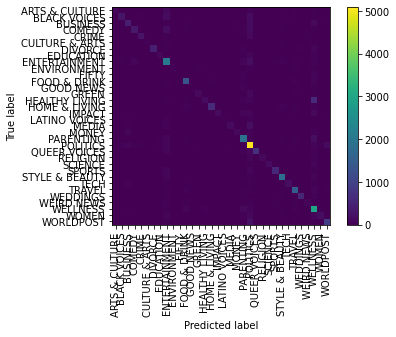

In [30]:
plot_confusion_matrix(Lg, x_test, 
                      y_test,xticks_rotation='vertical', 
                      include_values=False)

In [31]:
pickle.dump(Lg,open("LogisticRegression_model.pkl","wb"))